<a href="https://colab.research.google.com/github/potesd/ML-Experiments/blob/master/Copy_of_Fritz_Style_Transfer_Train_your_own_style_in_minutes!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fritz Style Transfer

Train your own mobile-friendly style transfer model in minutes. Choose a style, train a model, and download a saved version in Keras, Core ML, or TensorFlow Lite formats.

* To skip the training and get started quickly, head over to [Fritz](https://fritz.ai). 
* To see the final result, try our demo app, Heartbeat, available for both [iOS](bit.ly/heartbeat-ios) and [Android](bit.ly/heartbeat-android). 
* To dive into the soure code, head over to our [GitHub repository](https://github.com/fritzlabs/fritz-models/tree/master/style_transfer). If you find it useful, **star the repository**!

To get started training, **copy this notebook by hittig the "OPEN IN PLAYGROUND" button at the top of the page.**

In [0]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install keras==2.2.4
!pip install git+https://github.com/apple/coremltools.git@v2.1

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-ldh5zkq5
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-ldh5zkq5
  Stored in directory: /tmp/pip-ephem-wheel-cache-rl_r4ex7/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
  Cloning https://github.com/apple/coremltools.git (to revision v2.1) to /tmp/pip-req-build-kztbry5k
  Running command git clone -q https://github.com/apple/coremltools.git /tmp/pip-req-build-kztbry5k
  Running command git checkout -q 13c064ed99ab1da7abea0196e4ddf663ede48aad
  Stored in directory: /tmp/pip-ephem-wheel-cache-gyusx5v9/wheels/97/3f/df/98b399d386af6ec82bc43ba61a44f40b5fc8369aea73c6d1c9
Successfully built coremltools


In [0]:
import sys
import PIL.Image
import os
from IPython.utils import io

## Clone the Fritz Style Transfer Repository

In [0]:
# Install git lfs first so we can get download model checkpoints
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!apt-get install git-lfs
!git lfs install

Detected operating system as Ubuntu/bionic.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 44 not upgraded.
Need to get 5,730 kB of archives.
After this operation, 13.9 MB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu bionic/main amd64 git-lfs amd64 2.7.2 [5,730 kB]
Fetched 5,730 kB in 1s (9,546 kB/s)
Selecting previously unselec

In [0]:
!git clone https://github.com/fritzlabs/fritz-models.git

Cloning into 'fritz-models'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 896 (delta 28), reused 73 (delta 16), pack-reused 802
Receiving objects: 100% (896/896), 9.83 MiB | 32.69 MiB/s, done.
Resolving deltas: 100% (485/485), done.
Filtering content: 100% (13/13), 220.25 MiB | 72.56 MiB/s, done.


In [0]:
# Add the Fritz Style Transfer package to your python path
sys.path.append('/content/fritz-models/style_transfer/')

In [0]:
!mkdir fritz-models/style_transfer/data/

## Choose a style

Not all style images are equal. For the best results, pick images that:


1.   Have large geometric patterns on the scale of 10% - 33% of the images width
2.   Have bold, contrasting color palletes
3.   Have strong edges

If you're looking for inspiration, consider searching [Unslash](https://unspalsh.com) for [Flickr](https://www.flickr.com/search/) for terms like "abstract" or "geometric".

Make sure any images you use have an appropriate license.


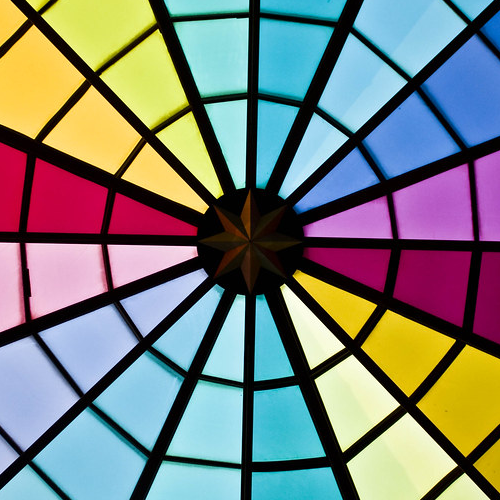

In [0]:
#@title Choose an image
#@markdown Enter the URL of the style image you want to use. The default is taking from here: https://flic.kr/p/8QaLwY
image_url = "https://www.google.com/url?sa=i&source=images&cd=&ved=2ahUKEwiHhfa40drjAhXwQ98KHSgHDl0QjRx6BAgBEAU&url=https%3A%2F%2Fwww.wired.com%2Fgallery%2Fbest-trail-running-shoes-round-up%2F&psig=AOvVaw25kkpVgET4PuBKtPL6GoPJ&ust=1564507148349150" #@param {type:"string"}

#@markdown Optionally add crop to create a better pattern. You may not need this
crop_image = True #@param {type:"boolean"}
if crop_image:
    crop_box = [250, 100, 750, 600] #@param {type:"raw"}


with io.capture_output(stderr=False) as captured:
    !cd fritz-models/style_transfer/data/ && wget -O style_image.jpg $image_url

style_image = image = PIL.Image.open('fritz-models/style_transfer/data/style_image.jpg')

if crop_image:
    style_image = style_image.crop(box=[250, 100, 750, 600])

style_image



## Download Training Data

We will use the 5000 images from the [COCO 2017 validation](http://cocodataset.org/#download) dataset for training.

In [0]:
training_data_url = "http://images.cocodataset.org/zips/val2017.zip"

!cd fritz-models/style_transfer/data/ && wget $training_data_url

print("Unzipping")
with io.capture_output(stderr=False):
    !unzip -o -d fritz-models/style_transfer/data/ fritz-models/style_transfer/data/val2017.zip

print(f"Finished Downloading data")

## Convert Training Data to TFRecord

This typically takes a minute or two to run.

In [0]:
!python fritz-models/style_transfer/create_training_dataset.py \
--output fritz-models/style_transfer/data/training_images.tfrecord \
--image-dir fritz-models/style_transfer/data/val2017/


python3: can't open file 'fritz-models/style_transfer/create_training_dataset.py': [Errno 2] No such file or directory


In [0]:
!cd fritz-models/style_transfer/ && export PYTHONPATH=`pwd` && python style_transfer/train.py \
--training-image-dset data/training_images.tfrecord \
--style-images data/style_image.jpg \
--model-checkpoint data/my_style_025.h5 \
--image-size 256,256 \
--alpha 0.25 \
--num-iterations 500 \
--batch-size 24 \
--style-weight 0.00001 \
--fine-tune-checkpoint example/starry_night_256x256_025.h5


## Stylize an image!

In [0]:
#@title Build Model
import style_transfer.models
import keras
from PIL import Image
from matplotlib import pyplot
import requests
from io import BytesIO
import numpy
from IPython.display import Markdown



def download_image(image_url):
    response = requests.get(image_url)
    return PIL.Image.open(BytesIO(response.content))


def run_prediction(model, image, image_size):
    image = image.resize(image_size)
    input_data = numpy.array(image)[None, :, :, :3] - 120.0
    output_data = model.predict(input_data)
    return PIL.Image.fromarray(output_data[0].astype('uint8'))


# Clear the keras session of the training we just did
keras.backend.clear_session()
# Load the model
image_size = (640, 640) #@param {type:"raw"}
model = style_transfer.models.StyleTransferNetwork.build(
    image_size,
    alpha=0.25, 
    checkpoint_file='/content/fritz-models/style_transfer/data/my_style_025.h5'
)

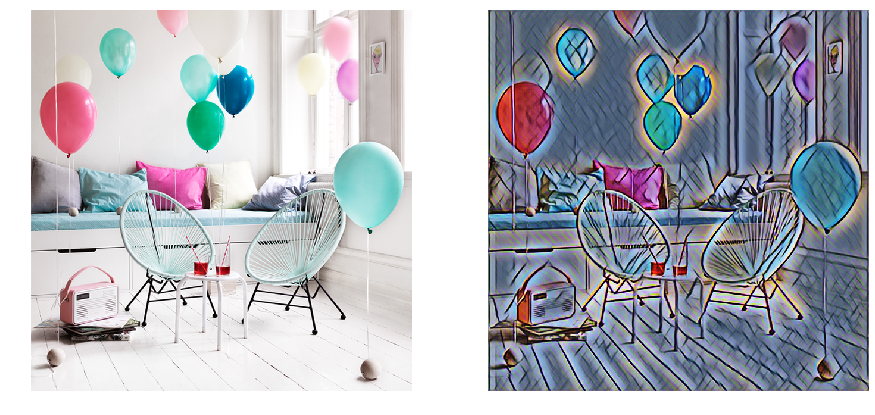

In [0]:
#@title Stylize an Image!
image_url = 'https://farm3.staticflickr.com/2907/14746369554_b783ba8d13_o_d.png' #@param {type:"string"}
image = download_image(image_url)
stylized_image = run_prediction(model, image, image_size)

fig, ax = pyplot.subplots(1,2);
fig.set_size_inches(15, 7)
ax[0].axis('off')
ax[1].axis('off')

ax[0].imshow(image);
ax[1].imshow(stylized_image);



In [0]:
# Download the model
from google.colab import files
files.download('/content/fritz-models/style_transfer/data/my_style_025.h5')

## Convert out model to Core ML

In [0]:
!python fritz-models/style_transfer/convert_to_coreml.py \
--keras-checkpoint fritz-models/style_transfer/data/my_style_025.h5 \
--alpha 0.25 \
--image-size 640,640 \
--coreml-model fritz-models/style_transfer/data/my_style_025.mlmodel


python3: can't open file 'fritz-models/style_transfer/convert_to_coreml.py': [Errno 2] No such file or directory


In [0]:
# Download the mlmodel
from google.colab import files
files.download('/content/fritz-models/style_transfer/data/my_style_025.mlmodel')

## Convert to TensorFlow Lite

In [0]:
!python fritz-models/style_transfer/convert_to_tflite.py \
--keras-checkpoint fritz-models/style_transfer/data/my_style_025.h5 \
--alpha 0.25 \
--image-size 400,300 \
--tflite-file fritz-models/style_transfer/data/my_style_025.tflite


In [0]:
# Download the optimized graph
from google.colab import files

files.download('/content/fritz-models/style_transfer/data/my_style_025.tflite')

# Upload and deploy models to your app with the Fritz Python Client

Constantly downloading models, dragging them into Xcode, and waiting for your app to build is a pain. To make the process faster and easier, we've created a Python client that allows new versions of models to be uploaded to Fritz and pushed to devices after or even during training.

Here's how it works:

1. If you don't already have one, create a [Fritz account](https://fritz.ai).
2. In the Account Menu under My Account, copy the configure command, which sets up the configuration to authenticate requests made from the Python Client.
3. Use the code below to send new versions of the model to your app via Fritz.

## Train the model

With a GPU attached, you should be able to use a batch size of 24 images. With a batch size of 24, 500 iteratorations should be fine to get us to 12,000 total steps. Because the style we've chosen is highly geometric with a large pattern, lets decrease the style weight by a factor of 10 to make the output look more like the original pictures.

Training on a GPU takes about 20 minutes. If you get memory errors, it probably means your runtime is trying to use the CPU or your batch size is too big. Training on TPUs is not yet supported.

In [0]:
!pip install fritz

In [0]:
!fritz config
!fritz model upload fritz-stable-style-transfer/data/my_style_025.mlmodel